In [1]:
# 1. MONTAR GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. IMPORTACIONES BÁSICAS
import os
from PIL import Image
from datasets import load_metric, Dataset
#from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch

# Usar GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [3]:
# 3. DEFINIR PATHS

base_dir = "/content/drive/MyDrive/Colab Notebooks/VPCIII/TFINAL"
model_path = os.path.join(base_dir, "models/finetuned_trocr")

In [4]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

# Cargar modelo y processor
processor = TrOCRProcessor.from_pretrained(model_path)
model = VisionEncoderDecoderModel.from_pretrained(model_path)
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.to(device)
model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/VPCIII/TFINAL/models/finetuned_trocr and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

🖼 Imagen: /content/drive/MyDrive/Colab Notebooks/VPCIII/TFINAL/val2014_recortes/467763_146522.jpg
📄 Texto asociado: /content/drive/MyDrive/Colab Notebooks/VPCIII/TFINAL/val2014_recortes/467763_146522.txt


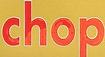

✅ Texto OCR real: chop
📝 Texto predicho: chop
✅ CER: 0.03448275862068961


In [7]:
import os
import random
from PIL import Image
import re
import glob
import torch
from IPython.display import display

def levenshtein_distance(s1: str, s2: str) -> int:
    """Calculate the Levenshtein distance between two strings."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def character_accuracy(predicted: str, ground_truth: str) -> float:
    """Calculate character-level accuracy."""
    if len(ground_truth) == 0:
        return 1.0 if len(predicted) == 0 else 0.0
    edit_distance = levenshtein_distance(predicted, ground_truth)
    return 1.0 - (edit_distance / len(ground_truth)) # CER is normalized by GT length

def normalize_text(text: str) -> str:
    """Normalize text for comparison (lowercase, strip whitespace)."""
    return re.sub(r'\s+', ' ', text.strip().lower())

# Probar con una imagen del set de validación
val_dir = os.path.join(base_dir, "val2014_recortes")

# Obtener todos los nombres base que tengan .jpg y .txt
files = os.listdir(val_dir)
jpg_files = [f[:-4] for f in files if f.endswith(".jpg")]
valid_pairs = [f for f in jpg_files if f + ".txt" in files]

# Elegir uno al azar
random_sample = random.choice(valid_pairs)
jpg_path = os.path.join(val_dir, random_sample + ".jpg")
txt_path = os.path.join(val_dir, random_sample + ".txt")

# Mostrar resultado
print(f"🖼 Imagen: {jpg_path}")
print(f"📄 Texto asociado: {txt_path}")

# Abrir imagen y texto
image = Image.open(jpg_path).convert("RGB")
with open(txt_path, "r", encoding="utf-8") as f:
    label = f.read().strip()

# Mostrar
display(image)
print(f"✅ Texto OCR real: {label}")

pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

with torch.no_grad():
  generated_ids = model.generate(pixel_values)

prediction = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

prediccion_normalizada = normalize_text(prediction)
label_normalizada = normalize_text(txt_path)
char_accuracy = character_accuracy(prediccion_normalizada, label_normalizada)

print("📝 Texto predicho:", prediction)
print("✅ CER:", char_accuracy)

In [8]:
# ESTA PARTE ES PARA VISUALIZACION DE ATENCIÓN
#from transformers import TrOCRProcessor, VisionEncoderDecoderModel
#from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuración
#image_path = os.path.join(base_dir, "music.jpg") # Imagen recortada
att_image_path = os.path.join(base_dir, "retro.jpg") # Imagen recortada
att_output_path = os.path.join(base_dir, "trocr_attention.jpg") # Salida

📝 Texto predicho: RETRO


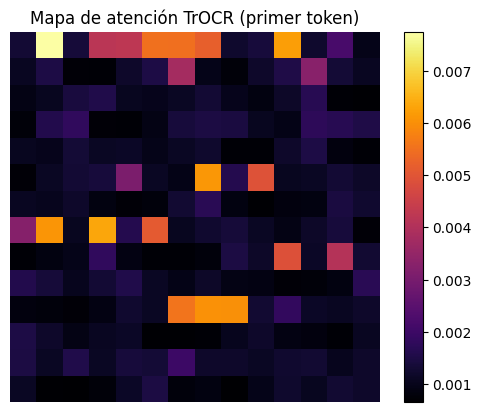

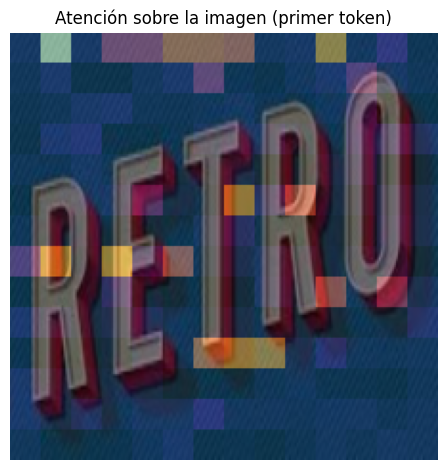

In [14]:
# Procesar imagen
image = Image.open(att_image_path).convert("RGB")
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values

# Dispositivo correcto
device = model.device
pixel_values = pixel_values.to(device)

# Token inicial
decoder_input_ids = torch.tensor([[model.config.decoder.bos_token_id]], device=device)

# 🔍 Ejecutar modelo con atención activada
with torch.no_grad():
    outputs = model(
        pixel_values=pixel_values,
        decoder_input_ids=decoder_input_ids,
        output_attentions=True,
        return_dict=True
    )

# Decodificar predicción completa
generated_ids = model.generate(pixel_values)
prediction = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Mostrar predicción
print(f"📝 Texto predicho: {prediction}")

# 🔎 Obtener mapa de atención del primer token generado
# outputs.cross_attentions es una lista: [layer1, layer2, ...]
# Cada layer tiene [batch, num_heads, tgt_len, src_len]
cross_attn = outputs.cross_attentions[0]  # primera capa
attn_map = cross_attn[0].mean(dim=0)[0]   # promedio sobre heads y tomar token 0

# Reshape a 14x14 si usás ViT-base (224/16 = 14)
#attn_map = attn_map.cpu().numpy().reshape(14, 14)
attn_map = attn_map.cpu().numpy()
attn_map_trimmed = attn_map[:196]  # solo los primeros 196 tokens
attn_map_2d = attn_map_trimmed.reshape(14, 14)

# Visualizar mapa de atención
plt.imshow(attn_map_2d, cmap='inferno')
plt.colorbar()
plt.title("Mapa de atención TrOCR (primer token)")
plt.axis('off')
plt.show()

# Mostrar imagen + atención
fig, ax = plt.subplots()
ax.imshow(image.resize((224, 224)))  # para alinear con atención
#ax.imshow(np.kron(attn_map, np.ones((16, 16))), cmap='inferno', alpha=0.5)
ax.imshow(np.kron(attn_map_2d, np.ones((16, 16))), cmap='inferno', alpha=0.5)
ax.axis('off')
plt.title("Atención sobre la imagen (primer token)")
plt.tight_layout()
plt.show()

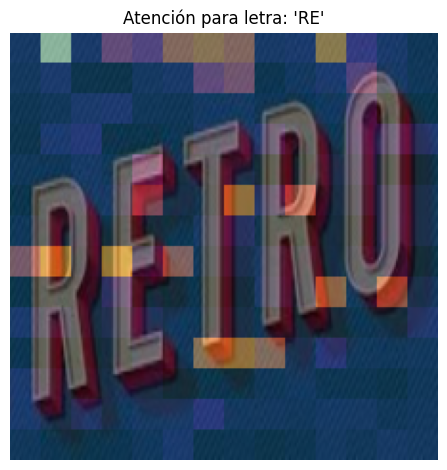

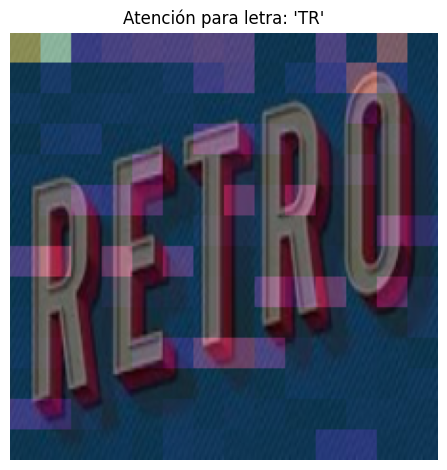

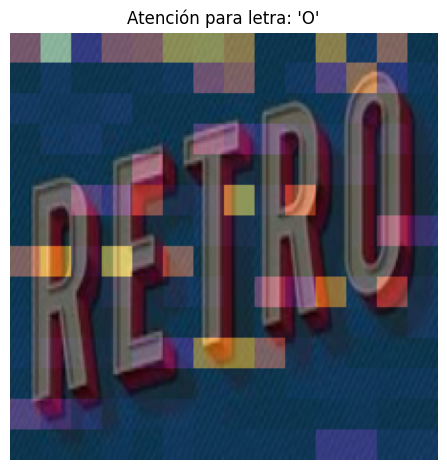

📝 Texto completo generado: RETRO


In [17]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Configuración
model.eval()
device = model.device

image = Image.open(att_image_path).convert("RGB").resize((224, 224))
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values.to(device)

# Token inicial
decoder_input_ids = torch.tensor([[model.config.decoder.bos_token_id]], device=device)
generated_text = ""

# Generar paso a paso
for step in range(10):  # máximo 10 caracteres por ejemplo
    with torch.no_grad():
        outputs = model(
            pixel_values=pixel_values,
            decoder_input_ids=decoder_input_ids,
            output_attentions=True,
            return_dict=True
        )

    # Decodificar último token generado
    next_token_id = outputs.logits[:, -1, :].argmax(-1).unsqueeze(0)
    token_text = processor.tokenizer.decode(next_token_id[0], skip_special_tokens=True)

    if token_text in ["", processor.tokenizer.eos_token]:
        break

    generated_text += token_text
    decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)

    # Obtener atención de este paso
    attn = outputs.cross_attentions[0][0]  # [heads, tgt_len, src_len]
    attn_vector = attn.mean(0)[-1]         # último token
    attn_map = attn_vector[:196].cpu().numpy().reshape(14, 14)
    attn_resized = np.kron(attn_map, np.ones((16, 16)))  # 14x14 → 224x224

    # Mostrar atención sobre imagen
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.imshow(attn_resized, cmap="inferno", alpha=0.5)
    ax.set_title(f"Atención para letra: '{token_text}'")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

print(f"📝 Texto completo generado: {generated_text}")


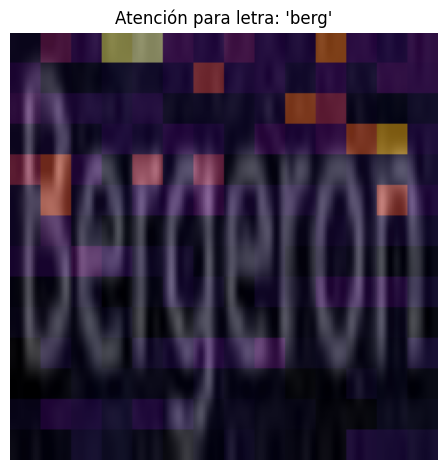

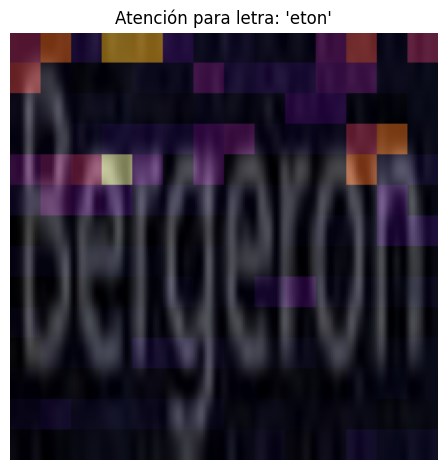

📝 Texto completo generado: bergeton


In [38]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Configuración
model.eval()
device = model.device

# Elegir una imagen al azar
random_sample = random.choice(valid_pairs)
jpg_path = os.path.join(val_dir, random_sample + ".jpg")

image = Image.open(jpg_path).convert("RGB").resize((224, 224))
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values.to(device)

# Token inicial
decoder_input_ids = torch.tensor([[model.config.decoder.bos_token_id]], device=device)
generated_text = ""

# Generar paso a paso
for step in range(10):  # máximo 10 caracteres por ejemplo
    with torch.no_grad():
        outputs = model(
            pixel_values=pixel_values,
            decoder_input_ids=decoder_input_ids,
            output_attentions=True,
            return_dict=True
        )

    # Decodificar último token generado
    next_token_id = outputs.logits[:, -1, :].argmax(-1).unsqueeze(0)
    token_text = processor.tokenizer.decode(next_token_id[0], skip_special_tokens=True)

    if token_text in ["", processor.tokenizer.eos_token]:
        break

    generated_text += token_text
    decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)

    # Obtener atención de este paso
    attn = outputs.cross_attentions[0][0]  # [heads, tgt_len, src_len]
    attn_vector = attn.mean(0)[-1]         # último token
    attn_map = attn_vector[:196].cpu().numpy().reshape(14, 14)
    attn_resized = np.kron(attn_map, np.ones((16, 16)))  # 14x14 → 224x224

    # Mostrar atención sobre imagen
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.imshow(attn_resized, cmap="inferno", alpha=0.5)
    ax.set_title(f"Atención para letra: '{token_text}'")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

print(f"📝 Texto completo generado: {generated_text}")

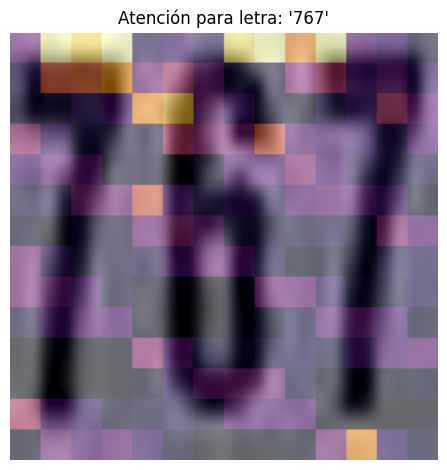

📝 Texto completo generado: 767


In [50]:
# Configuración
model.eval()
device = model.device

# Elegir una imagen al azar
random_sample = random.choice(valid_pairs)
jpg_path = os.path.join(val_dir, random_sample + ".jpg")

image = Image.open(jpg_path).convert("RGB").resize((224, 224))
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values.to(device)

# Token inicial
decoder_input_ids = torch.tensor([[model.config.decoder.bos_token_id]], device=device)
generated_text = ""

# Generar paso a paso
for step in range(10):  # máximo 10 caracteres por ejemplo
    with torch.no_grad():
        outputs = model(
            pixel_values=pixel_values,
            decoder_input_ids=decoder_input_ids,
            output_attentions=True,
            return_dict=True
        )

    # Decodificar último token generado
    next_token_id = outputs.logits[:, -1, :].argmax(-1).unsqueeze(0)
    token_text = processor.tokenizer.decode(next_token_id[0], skip_special_tokens=True)

    if token_text in ["", processor.tokenizer.eos_token]:
        break

    generated_text += token_text
    decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)

    # Obtener atención de este paso
    attn = outputs.cross_attentions[0][0]  # [heads, tgt_len, src_len]
    attn_vector = attn.mean(0)[-1]         # último token
    attn_map = attn_vector[:196].cpu().numpy().reshape(14, 14)
    attn_resized = np.kron(attn_map, np.ones((16, 16)))  # 14x14 → 224x224

    # Mostrar atención sobre imagen
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.imshow(attn_resized, cmap="inferno", alpha=0.5)
    ax.set_title(f"Atención para letra: '{token_text}'")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

print(f"📝 Texto completo generado: {generated_text}")